<a href="https://colab.research.google.com/github/Sravani9544/projects/blob/main/AppliedAICourse_Assignments/05_Amazon_Fine_Food_Reviews_Analysis_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect(r'D:\python\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text
FROM Reviews
GROUP BY Time
""", con)

In [ ]:
print(display.shape)
display.head()

(3168, 6)


,UserId,ProductId,ProfileName,Time,Score,Text
0,ACITT7DI6IDDL,0006641040,shari zychinski,939340800,5,this witty little book makes my son laugh at l...
1,AJ46FKXOVC7NR,0006641040,Nicholas A Mesiano,940809600,5,I can remember seeing the show when it aired o...
2,AIUWLEQ1ADEG5,B00004CXX9,Elizabeth Medina,944092800,5,Beetlejuice is a well written movie ..... ever...
3,A344SMIA5JECGM,B00004RYGX,Vincent P. Ross,944438400,5,"A twist of rumplestiskin captured on film, sta..."
4,AJH6LUC1UT1ON,B00004CXX9,The Phantom of the Opera,946857600,5,Beetlejuice is an excellent and funny movie. K...


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY Time
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","ProductId","Time","Text"}, keep='first', inplace=False)
final.shape

(524691, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.78642637890965

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY Time
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(524689, 10)


1    442966
0     81723
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
Having remembered Red Velvet cake from the south as a child, I found this cake mix to be excellent and it has received rave reviews from adults and kids alike.  Rich like chocolate, but lighter - this is a solid favorite of all who try it for the first time. The color is enticing to some, scary to others, but once tasted - with a cream cheese frosting - all are fans.  Easy to make, perfect every time!
I paid over $13.00 for "expedited" delivery and the product still took FIVE days to arrive. Would not buy from them again.
This loose tea is hard to find in stores, I had to order it online and discovered it's a better 

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, "html.parser")
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, "html.parser")
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, "html.parser")
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, "html.parser")
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
Having remembered Red Velvet cake from the south as a child, I found this cake mix to be excellent and it has received rave reviews from adults and kids alike.  Rich like chocolate, but lighter - this is a solid favorite of all who try it for the first time. The color is enticing to some, scary to others, but once tasted - with a cream cheese frosting - all are fans.  Easy to make, perfect every time!
I paid over $13.00 for "expedited" delivery and the product still took FIVE days to arrive. Would not buy from them again.
This loose tea is hard to find in stores, I had to order it online and discovered it's a better 

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I paid over $13.00 for "expedited" delivery and the product still took FIVE days to arrive. Would not buy from them again.


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I paid over 13 00 for expedited delivery and the product still took FIVE days to arrive Would not buy from them again 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, "html.parser").get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 524689/524689 [02:06<00:00, 4155.48it/s]


In [ ]:
preprocessed_reviews[1500]

'paid expedited delivery product still took five days arrive would not buy'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [ ]:
# printing some random reviews
sravs_0 = final['Summary'].values[0]
print(sravs_0)
print("="*50)

sravs_1000 = final['Summary'].values[1000]
print(sravs_1000)
print("="*50)

sravs_1500 = final['Summary'].values[1500]
print(sravs_1500)
print("="*50)

sravs_4900 = final['Summary'].values[4900]
print(sravs_4900)
print("="*50)

EVERY book is educational
Red Velvet Cake - Surprisingly Delicious
Don't pay for "expedited" delivery
lipton loose tea


In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sravs_0 = re.sub(r"http\S+", "", sravs_0)
sravs_1000 = re.sub(r"http\S+", "", sravs_1000)
sravs_1500 = re.sub(r"http\S+", "", sravs_1500)
sravs_4900 = re.sub(r"http\S+", "", sravs_4900)

print(sravs_0)

EVERY book is educational


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sravs_0, "html.parser")
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sravs_1000, "html.parser")
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sravs_1500, "html.parser")
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sravs_4900, "html.parser")
text = soup.get_text()
print(text)

EVERY book is educational
Red Velvet Cake - Surprisingly Delicious
Don't pay for "expedited" delivery
lipton loose tea


In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sravs_1500 = decontracted(sravs_1500)
print(sravs_1500)
print("="*50)

Do not pay for "expedited" delivery


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sravs_0 = re.sub("\S*\d\S*", "", sravs_0).strip()
print(sravs_0)

EVERY book is educational


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sravs_1500 = re.sub('[^A-Za-z0-9]+', ' ', sravs_1500)
print(sravs_1500)

Do not pay for expedited delivery


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, "html.parser").get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 524689/524689 [00:54<00:00, 9543.90it/s]


In [ ]:
preprocessed_summary[1500]

'not pay expedited delivery'

In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [ ]:
preprocessed_reviews = [i + ' ' + j for i, j in zip(preprocessed_reviews,preprocessed_summary)] 
print(preprocessed_reviews[1500])

paid expedited delivery product still took five days arrive would not buy not pay expedited delivery


In [ ]:
data_pos = final[final["Score"]== 1].sample(n = 80000)
data_neg = final[final["Score"]== 0].sample(n = 20000)
final_2000 = pd.concat([data_pos,data_neg])

In [ ]:
final_2000["Time"] = pd.to_datetime(final_2000["Time"], unit = "s")
final_2000 = final_2000.sort_values(by = "Time")

In [ ]:
final_2000.shape

(100000, 10)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X = final_2000['Text']
X.shape
Y = final_2000['Score']
Y.shape
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33) # this is random splitting


In [ ]:
print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)


In [ ]:
type(X_train)

pandas.core.series.Series

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)
print("some feature names ", count_vect.get_feature_names()[:10])
print("the type of count vectorizer", type(X_train_bow))
print("the shape of out text BOW vectorizer", X_train_bow.get_shape())
print("the number of unique words", X_train_bow.get_shape()[1])
print('='*50)

some feature names  ['00', '000', '0000', '00001', '0004', '000kwh', '000mg', '000s', '00127', '00128']
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer (44890, 39890)
the number of unique words 39890


In [ ]:
from sklearn.preprocessing import StandardScaler 
std_data = StandardScaler(with_mean = False).fit(X_train_bow)
std_data_train = std_data.transform(X_train_bow)
std_data_train.shape

(44890, 39890)

In [ ]:
from sklearn.preprocessing import StandardScaler 
std_data_test = std_data.transform(X_test_bow)
std_data_test.shape

(33000, 39890)

In [ ]:
std_data_cv = std_data.transform(X_cv_bow)
std_data_cv.shape

(22110, 39890)

In [ ]:
print("After bow")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*50)

After bow
(44890, 39890) (44890,)
(22110, 39890) (22110,)
(33000, 39890) (33000,)


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (44890, 5000)
the number of unique words including both unigrams and bigrams  5000


In [ ]:
from sklearn.preprocessing import StandardScaler 
std_data = StandardScaler(with_mean = False).fit(final_bigram_counts)
std_data = std_data.transform(final_bigram_counts)
std_data.shape

(44890, 5000)

In [ ]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [ ]:
std_data = std_data.todense()
type(std_data)

numpy.matrix

## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['00', '00 and', '00 br', '00 for', '00 more', '00 per', '000', '01', '02', '03']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (44890, 49752)
the number of unique words including both unigrams and bigrams  49752


In [ ]:
X_train_tfidf = final_tf_idf

In [ ]:
X_train_tfidf.shape

(44890, 49752)

In [ ]:
X_test_tfidf = tf_idf_vect.transform(X_test)
X_test_tfidf.shape

(33000, 49752)

In [ ]:
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_cv_tfidf.shape

(22110, 49752)

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8786425590515137), ('wonderful', 0.8775689005851746), ('fantastic', 0.8578576445579529), ('perfect', 0.8015658855438232), ('delicious', 0.7758249640464783), ('awesome', 0.7495013475418091), ('nice', 0.7480167746543884), ('decent', 0.7465898990631104), ('excellent', 0.7399019598960876), ('fabulous', 0.7395161390304565)]
[('best', 0.8532296419143677), ('tastiest', 0.757768452167511), ('closest', 0.7540486454963684), ('BEST', 0.7525098323822021), ('nastiest', 0.7240918278694153), ('greatest', 0.6964240074157715), ('WORST', 0.6843296885490417), ('ever', 0.663214385509491), ('purchased!', 0.6519150733947754), ('nicest', 0.6193050146102905)]


In [ ]:
w2v_model= Word2Vec(list_of_sentance_train, min_count= 5, size = 50,workers = 4)

In [ ]:
len(list_of_sentance_train)

44890

In [ ]:
print(final_2000['Text'].values[0])
print('*********')
print(list_of_sentance_train[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*********
['First', 'had', 'these', 'delicious', 'Vegan', 'treats', 'when', 'I', 'was', 'visiting', 'my', 'sister', 'in', 'CA', 'and', "couldn't", 'find', 'them', 'in', 'MA!', 'Now', 'I', 'can', 'always', 'find', 'them', 'on', 'Amazon!', 'They', 'are', 'tasty', 'low', 'fat,', 'hight', 'protein,', 'a', 'bit', 'high', 'in', 'sodium,', 'portable', 'and', 'easy', 'to', 'take', 'with', 'me', 'where', 'ever', 'I', 'go!']


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  25819
sample words  ['First', 'had', 'these', 'delicious', 'Vegan', 'treats', 'when', 'I', 'was', 'visiting', 'my', 'sister', 'in', 'CA', 'and', "couldn't", 'find', 'them', 'Now', 'can', 'always', 'on', 'Amazon!', 'They', 'are', 'tasty', 'low', 'fat,', 'protein,', 'a', 'bit', 'high', 'sodium,', 'portable', 'easy', 'to', 'take', 'with', 'me', 'where', 'ever', 'go!', 'WOW.', 'so', 'many', 'salt', 'vinegar', 'snacks', "i've", 'only']


In [ ]:
w2v_model.wv.most_similar('like')

[('like,', 0.7315455675125122),
 ('like.', 0.6505230069160461),
 ('prefer', 0.6346548199653625),
 ('miss', 0.5769685506820679),
 ('enjoy', 0.5763070583343506),
 ('think', 0.5566756725311279),
 ('love', 0.5408781170845032),
 ('expect', 0.5243402123451233),
 ('crave', 0.5239968299865723),
 ('want', 0.5235675573348999)]

In [ ]:
i = 0
list_of_sent_test = []
for sent in X_test:
    list_of_sent_test.append(sent.split())

In [ ]:
len(list_of_sent_test)

33000

In [ ]:
i = 0
list_of_sent_cv = []
for sent in X_cv:
    list_of_sent_cv.append(sent.split())

In [ ]:
len(list_of_sent_cv)

22110

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 44890/44890 [07:29<00:00, 99.76it/s]


44890
50


In [ ]:
X_train_avgw2v = sent_vectors

In [ ]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|████████████████████████████████████████████████████████████████████████████| 33000/33000 [05:33<00:00, 98.92it/s]


33000
50


In [ ]:
X_test_avgw2v = sent_vectors_test

In [ ]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [03:44<00:00, 98.41it/s]


22110
50


In [ ]:
X_cv_avgw2v = sent_vectors_cv

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 44890/44890 [35:52<00:00, 21.08it/s]


In [ ]:
X_train_tfidfw2v = tfidf_sent_vectors

In [ ]:
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sent_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 33000/33000 [25:33<00:00, 21.53it/s]


In [ ]:
X_test_tfidfw2v = tfidf_sent_vectors_test

In [ ]:
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sent_cv): 
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [16:47<00:00, 21.96it/s]


In [ ]:
X_cv_tfidfw2v = tfidf_sent_vectors_cv

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [ ]:
def optimal_lamda(X_train_bow,Y_train,X_cv_bow,Y_cv):
    train_auc_l1 = []
    train_auc_l2 = []
    cv_auc_l1 = []
    cv_auc_l2 = []
    penalty = ['l1','l2']
    hyper_param = [10**i for i in range(-7,7)]

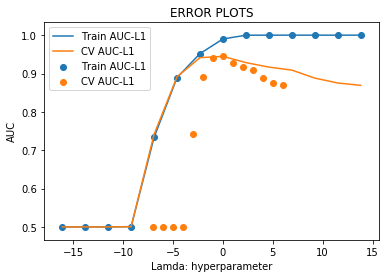

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
penalty = ['l1','l2']
hyper_param = [10**i for i in range(-7,7)]
train_auc_l1 = []
train_auc_l2 = []
cv_auc_l1 = []
cv_auc_l2 = []
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

for i in penalty:
    for j in hyper_param:
        clf = LogisticRegression(C=j, penalty=i)
        clf.fit(X_train_bow, Y_train)
        Y_train_pred =  clf.predict_proba(X_train_bow)[:,1] 
        Y_cv_pred =  clf.predict_proba(X_cv_bow)[:,1]
        if i == 'l1':
            train_auc_l1.append(roc_auc_score(Y_train,Y_train_pred)) 
            cv_auc_l1.append(roc_auc_score(Y_cv, Y_cv_pred))
        else:
            train_auc_l2.append(roc_auc_score(Y_train,Y_train_pred))
            cv_auc_l2.append(roc_auc_score(Y_cv, Y_cv_pred))
plt.plot(np.log(hyper_param), train_auc_l1, label='Train AUC-L1') 
plt.plot(np.log(hyper_param), cv_auc_l1, label='CV AUC-L1')
plt.scatter(np.log(hyper_param), train_auc_l1, label='Train AUC-L1') 
plt.scatter(np.log10(hyper_param), cv_auc_l1, label='CV AUC-L1')
plt.legend()
plt.xlabel("Lamda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()               

    

In [ ]:
clf = LogisticRegression(C=j, penalty= 'l1')
            

In [ ]:
clf.fit(X_train_bow,Y_train)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X_test_bow)
print(pred)

[1 1 1 ... 1 1 0]


In [ ]:
pred1 = clf.predict(X_train_bow)
print(pred1)

[1 1 1 ... 0 1 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[ 4551,  2005],
       [ 2441, 24003]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[ 9026,     0],
       [    0, 35864]], dtype=int64)

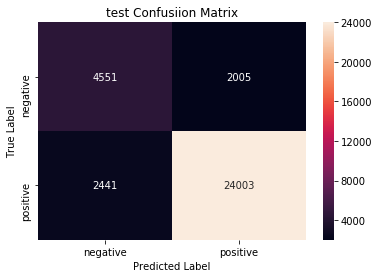

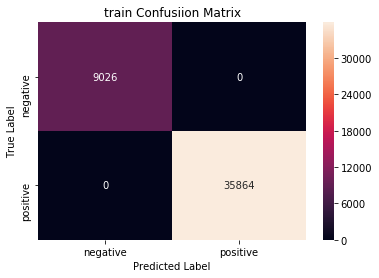

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("train classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.65      0.69      0.67      6556
           1       0.92      0.91      0.92     26444

   micro avg       0.87      0.87      0.87     33000
   macro avg       0.79      0.80      0.79     33000
weighted avg       0.87      0.87      0.87     33000

train classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9026
           1       1.00      1.00      1.00     35864

   micro avg       1.00      1.00      1.00     44890
   macro avg       1.00      1.00      1.00     44890
weighted avg       1.00      1.00      1.00     44890



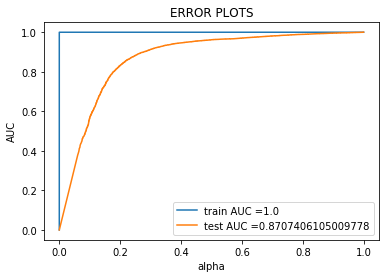

In [ ]:
from sklearn.metrics import roc_curve, auc


clf = LogisticRegression(C=j, penalty= 'l1')
clf.fit(X_train_bow, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, clf.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [ ]:
lr = LogisticRegression(C=1e5)
lr.fit(X_train_bow, Y_train)

print(lr.coef_) # returns a matrix of weights (coefficients)

[[-0.2092073  -0.80960091  1.27561162 ...  0.00181947  0.79355021
   0.17973264]]


In [ ]:
# calculate sparsity
from numpy import array
from numpy import count_nonzero
# calculate sparsity
sparsity = 1.0 - count_nonzero(lr.coef_) / lr.coef_.size
print(sparsity)

0.0


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

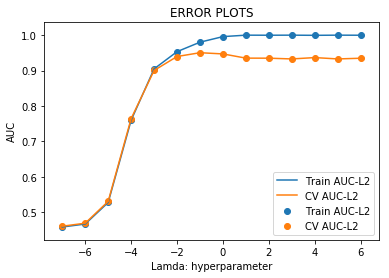

In [ ]:
plt.plot(np.log10(hyper_param), train_auc_l2, label='Train AUC-L2') 
plt.plot(np.log10(hyper_param), cv_auc_l2, label='CV AUC-L2')
plt.scatter(np.log10(hyper_param), train_auc_l2, label='Train AUC-L2') 
plt.scatter(np.log10(hyper_param), cv_auc_l2, label='CV AUC-L2')
plt.legend()
plt.xlabel("Lamda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
clf = LogisticRegression(C=j, penalty= 'l1')

In [ ]:
clf.fit(X_train_bow,Y_train)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X_test_bow)
print(pred)

[1 1 1 ... 1 1 0]


In [ ]:
pred1 = clf.predict(X_train_bow)
print(pred1)

[1 1 1 ... 0 1 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[ 4564,  1992],
       [ 2425, 24019]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[ 9026,     0],
       [    0, 35864]], dtype=int64)

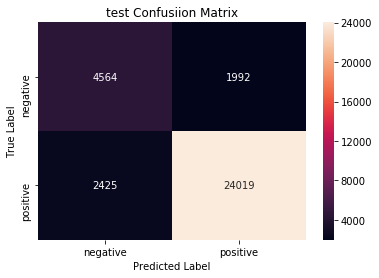

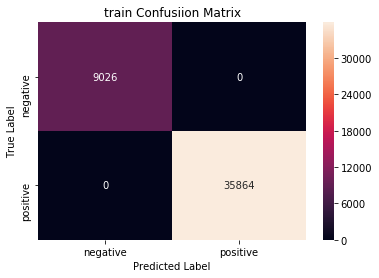

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("train classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.65      0.70      0.67      6556
           1       0.92      0.91      0.92     26444

   micro avg       0.87      0.87      0.87     33000
   macro avg       0.79      0.80      0.79     33000
weighted avg       0.87      0.87      0.87     33000

train classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9026
           1       1.00      1.00      1.00     35864

   micro avg       1.00      1.00      1.00     44890
   macro avg       1.00      1.00      1.00     44890
weighted avg       1.00      1.00      1.00     44890



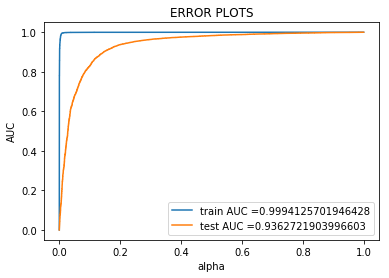

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


clf = LogisticRegression(C=j, penalty= 'l2')
clf.fit(X_train_bow, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, clf.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [ ]:
weights1=clf.coef_
print(weights1.shape)

(1, 39890)


In [ ]:
from copy import copy
from copy import deepcopy

In [ ]:
from copy import copy
from copy import deepcopy
x_trainp=deepcopy(X_train_bow) # Copying x_train into x_trainp
e=np.random.normal(0,0.01)
print(e)
x_trainp.data = x_trainp.data + e
print(X_train_bow.todense())
print(x_trainp.todense())

-0.0008741000058743627
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
#Calculating weights after adding noise
model = LogisticRegression(C= 0.01, penalty= 'l1')
model.fit(x_trainp,Y_train)
weights2=model.coef_
print(weights2.shape)

(1, 39890)


In [ ]:
#Adding small noise to avoid zero divide error
e=np.random.normal(0,0.001)
weights1+=e
weights2+=e


In [ ]:
weights_difference = np.abs((weights2-weights1)/weights1)*100
#print(weights_difference)
print(weights_difference.max())
print(weights_difference.min())
print(weights_difference.std())

1037222.1457840429
0.024117912096074466
5351.511830786806


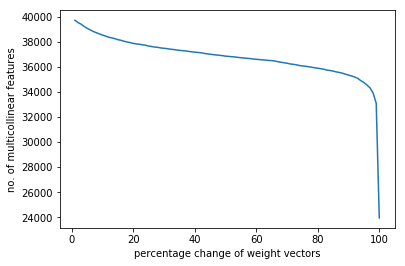

In [ ]:
percentage_change=[]
collinear_features=[]

for i in range(1,101):
    f=np.where(weights_difference > i)[1].size
    percentage_change.append(i)
    collinear_features.append(f)
    
plt.xlabel('percentage change of weight vectors')
plt.ylabel('no. of multicollinear features')
plt.plot(percentage_change,collinear_features)

In [ ]:
print("No of features have weight changes greater than 50%: ", weights_difference[np.where(weights_difference > 50)].size)
fe=[]
print("\nHence below features are collinear:")
for i in np.where(weights_difference > 50)[1]:
    fe.append(f)
print(fe[:10])

No of features have weight changes greater than 50%:  36844

Hence below features are collinear:
[23953, 23953, 23953, 23953, 23953, 23953, 23953, 23953, 23953, 23953]


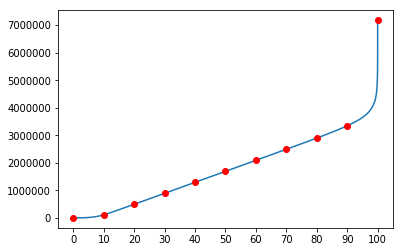

In [ ]:
from matplotlib import mlab
d = np.sort(weights_difference).cumsum()
p = np.array(range(0,101,10))
perc = mlab.prctile(d, p=p)
plt.plot(d)

# Place red dots on the percentiles
plt.plot((len(d)-1) * p/100., perc, 'ro')

# Set tick locations and labels
plt.xticks((len(d)-1) * p/100., map(str, p))

plt.show()

In [ ]:
print(np.percentile(weights_difference, 99.1))
print(np.percentile(weights_difference, 99.2))
print(np.percentile(weights_difference, 99.3))
print(np.percentile(weights_difference, 99.4))
print(np.percentile(weights_difference, 99.5))
print(np.percentile(weights_difference, 99.6))
print(np.percentile(weights_difference, 99.7))
print(np.percentile(weights_difference, 99.8))
print(np.percentile(weights_difference, 99.9))
print(np.percentile(weights_difference, 100))

938.4908116792731
1056.2374312629504
1223.8169863989478
1468.105756582012
1711.3030485752315
2324.574266921627
2806.6143183214117
4595.167465476958
8364.591203311906
1037222.1457840429


In [ ]:
# As per above analysis we can set 99.4 as threshold above which the weights are increased abruptly.
# Printed some the features from them

weights_difference[weights_difference > np.percentile(weights_difference,95)]
fe=[]
for i in np.where(weights_difference > np.percentile(weights_difference,99.4))[1]:
    fe.append(f)
print(fe[:10])
print("No of features: ",len(fe))

[23953, 23953, 23953, 23953, 23953, 23953, 23953, 23953, 23953, 23953]
No of features:  239


In [ ]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

In [ ]:
# Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
for i in [0.001,0.1,1,10,100,1000]:
    clf_l1 = LogisticRegression(C= i, penalty= 'l1')
    clf_l1.fit(X_train_bow,Y_train)
    y_pred = clf_l1.predict(X_test_bow)
    print("For C =",i)
    acc_bow = accuracy_score(Y_test, pred) * 100
    print("Accuracy on test set: %0.3f%%"%(acc_bow))
    print("F1-Score on test set: %0.3f"%(f1_score(Y_test, pred)))
    print("Non Zero weights:",np.count_nonzero(clf_l1.coef_))
    print("---------------")

For C = 0.001
Accuracy on test set: 86.615%
F1-Score on test set: 0.916
Non Zero weights: 11
---------------
For C = 0.1
Accuracy on test set: 86.615%
F1-Score on test set: 0.916
Non Zero weights: 863
---------------
For C = 1
Accuracy on test set: 86.615%
F1-Score on test set: 0.916
Non Zero weights: 4089
---------------
For C = 10
Accuracy on test set: 86.615%
F1-Score on test set: 0.916
Non Zero weights: 7174
---------------
For C = 100
Accuracy on test set: 86.615%
F1-Score on test set: 0.916
Non Zero weights: 8204
---------------
For C = 1000
Accuracy on test set: 86.615%
F1-Score on test set: 0.916
Non Zero weights: 10697
---------------


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

In [ ]:
def top_features(count_vect, clf, n):
    feature_names = count_vect.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

#### [5.1.3.1] Top 10 important features of positive class and negative class from<font color='red'> SET 1</font>

In [ ]:
top_features(count_vect, clf,10)

			Negative						Positive
________________________________________________________________________________________________
	-5.1518	regret         				4.3013	grade          
	-4.5961	pounds         				3.7952	cocoa          
	-3.8179	ship           				3.7822	you won        
	-3.7513	have them      				3.4827	loaded         
	-3.6759	we love        				3.3773	labeled        
	-3.6694	plants         				3.2081	myself         
	-3.6013	can use        				3.2063	she is         
	-3.5487	adding         				3.1001	prefers        
	-3.4451	is right       				2.9743	and don        
	-3.3540	you might      				2.9416	not even       


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

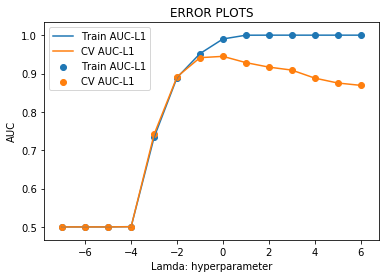

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
def optimal_lamda(X_train_tfidf,Y_train,X_cv_tfidf,Y_cv):
    train_auc_l1 = []
    train_auc_l2 = []
    cv_auc_l1 = []
    cv_auc_l2 = []
    penalty=['l1','l2']
    hyper_param=[10**i for i in range(-7,7)]
    for i in penalty:
        for j in  hyper_param:
            clf = LogisticRegression(C=j, penalty= i)
            clf.fit(X_train_tfidf, Y_train)
            Y_train_pred =  clf.predict_proba(X_train_tfidf)[:,1] 
            Y_cv_pred =  clf.predict_proba(X_cv_tfidf)[:,1]
            if i == 'l1':
                train_auc_l1.append(roc_auc_score(Y_train,Y_train_pred)) 
                cv_auc_l1.append(roc_auc_score(Y_cv, Y_cv_pred))
            else:
                train_auc_l2.append(roc_auc_score(Y_train,Y_train_pred))
                cv_auc_l2.append(roc_auc_score(Y_cv, Y_cv_pred))
                
plt.plot(np.log10(hyper_param), train_auc_l1, label='Train AUC-L1') 
plt.plot(np.log10(hyper_param), cv_auc_l1, label='CV AUC-L1')
plt.scatter(np.log10(hyper_param), train_auc_l1, label='Train AUC-L1') 
plt.scatter(np.log10(hyper_param), cv_auc_l1, label='CV AUC-L1')
plt.legend()
plt.xlabel("Lamda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

In [ ]:
clf = LogisticRegression(C=j, penalty= 'l1')

In [ ]:
clf.fit(X_train_tfidf,Y_train)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X_test_tfidf)
print(pred)

[1 1 1 ... 1 1 0]


In [ ]:
pred1 = clf.predict(X_train_tfidf)
print(pred1)

[1 1 1 ... 0 1 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[ 5130,  1426],
       [ 1429, 25015]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[ 9026,     0],
       [    0, 35864]], dtype=int64)

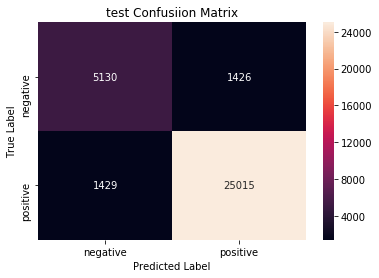

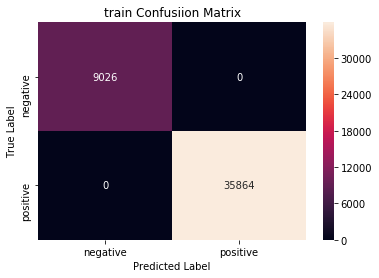

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("train classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      6556
           1       0.95      0.95      0.95     26444

   micro avg       0.91      0.91      0.91     33000
   macro avg       0.86      0.86      0.86     33000
weighted avg       0.91      0.91      0.91     33000

train classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9026
           1       1.00      1.00      1.00     35864

   micro avg       1.00      1.00      1.00     44890
   macro avg       1.00      1.00      1.00     44890
weighted avg       1.00      1.00      1.00     44890



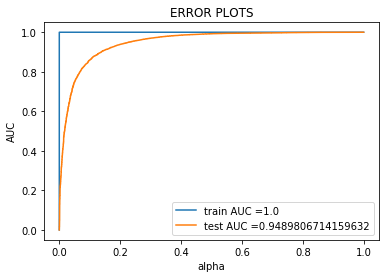

In [ ]:
from sklearn.metrics import roc_curve, auc


clf = LogisticRegression(C=j, penalty= 'l1')
clf.fit(X_train_tfidf, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, clf.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

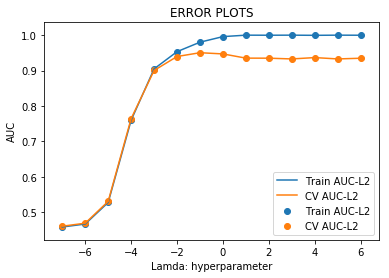

In [ ]:
plt.plot(np.log10(hyper_param), train_auc_l2, label='Train AUC-L2') 
plt.plot(np.log10(hyper_param), cv_auc_l2, label='CV AUC-L2')
plt.scatter(np.log10(hyper_param), train_auc_l2, label='Train AUC-L2') 
plt.scatter(np.log10(hyper_param), cv_auc_l2, label='CV AUC-L2')
plt.legend()
plt.xlabel("Lamda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
clf = LogisticRegression(C=j, penalty= 'l2')

In [ ]:
clf.fit(X_train_tfidf,Y_train)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X_test_tfidf)
print(pred)

[1 1 1 ... 1 1 0]


In [ ]:
pred1 = clf.predict(X_train_tfidf)
print(pred1)

[1 1 1 ... 0 1 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[ 5345,  1211],
       [  873, 25571]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[ 9026,     0],
       [    0, 35864]], dtype=int64)

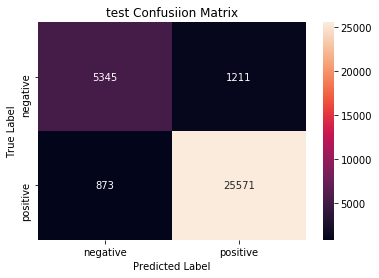

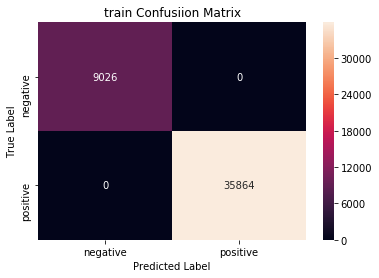

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("train classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      6556
           1       0.95      0.97      0.96     26444

   micro avg       0.94      0.94      0.94     33000
   macro avg       0.91      0.89      0.90     33000
weighted avg       0.94      0.94      0.94     33000

train classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9026
           1       1.00      1.00      1.00     35864

   micro avg       1.00      1.00      1.00     44890
   macro avg       1.00      1.00      1.00     44890
weighted avg       1.00      1.00      1.00     44890



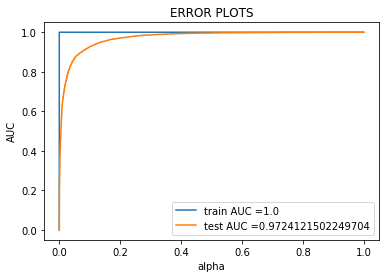

In [ ]:
from sklearn.metrics import roc_curve, auc


clf = LogisticRegression(C=j, penalty= 'l2')
clf.fit(X_train_tfidf, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, clf.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

In [ ]:
def top_features(count_vect, clf, n):
    feature_names = count_vect.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

#### [5.2.3.1] Top 10 important features of positive class and negative class from<font color='red'> SET 2</font>

In [ ]:
top_features(count_vect, clf,10)

			Negative						Positive
________________________________________________________________________________________________
	-35.7615	wanted to      				33.1517	haven tried    
	-35.1217	to pick        				32.8081	waffles        
	-27.6311	to make        				23.3651	carb           
	-19.8599	helps          				22.1269	weeks          
	-19.2049	ve tried       				20.1437	too and        
	-19.0677	product at     				17.3500	me of          
	-18.6039	and vinegar    				17.3040	this coffee    
	-18.4660	even the       				17.2679	pill pockets   
	-18.4312	does it        				17.0326	the directions 
	-18.0075	box was        				16.5659	earth best     


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

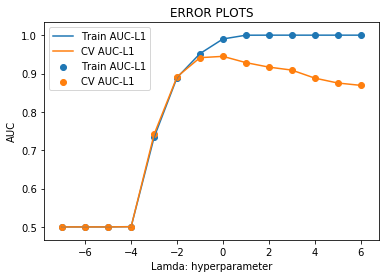

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
def optimal_lamda(X_train_avgw2v,Y_train,X_cv_avgw2v,Y_cv):
    train_auc_l1 = []
    train_auc_l2 = []
    cv_auc_l1 = []
    cv_auc_l2 = []
    penalty=['l1','l2']
    hyper_param=[10**i for i in range(-7,7)]
    for i in penalty:
        for j in  hyper_param:
            clf = LogisticRegression(C=j, penalty= i)
            clf.fit(X_train_avgw2v, Y_train)
            Y_train_pred =  clf.predict_proba(X_train_avgw2v)[:,1] 
            Y_cv_pred =  clf.predict_proba(X_cv_avgw2v)[:,1]
            if i == 'l1':
                train_auc_l1.append(roc_auc_score(Y_train,Y_train_pred)) 
                cv_auc_l1.append(roc_auc_score(Y_cv, Y_cv_pred))
            else:
                train_auc_l2.append(roc_auc_score(Y_train,Y_train_pred))
                cv_auc_l2.append(roc_auc_score(Y_cv, Y_cv_pred))
                
plt.plot(np.log10(hyper_param), train_auc_l1, label='Train AUC-L1') 
plt.plot(np.log10(hyper_param), cv_auc_l1, label='CV AUC-L1')
plt.scatter(np.log10(hyper_param), train_auc_l1, label='Train AUC-L1') 
plt.scatter(np.log10(hyper_param), cv_auc_l1, label='CV AUC-L1')
plt.legend()
plt.xlabel("Lamda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

In [ ]:
clf = LogisticRegression(C=j, penalty= 'l1')

In [ ]:
clf.fit(X_train_avgw2v,Y_train)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X_test_avgw2v)
print(pred)

[1 1 1 ... 1 0 1]


In [ ]:
pred1 = clf.predict(X_train_avgw2v)
print(pred1)

[1 1 1 ... 0 1 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[ 2839,  3717],
       [ 1280, 25164]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[ 4018,  5008],
       [ 1732, 34132]], dtype=int64)

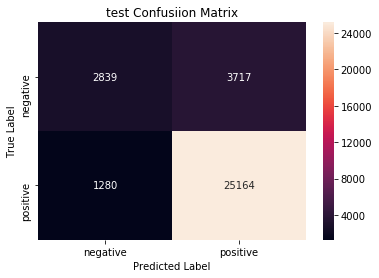

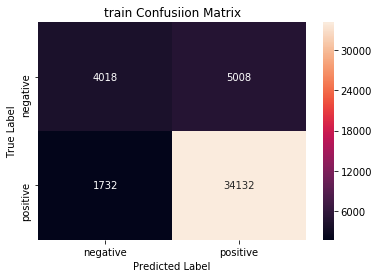

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("train classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.69      0.43      0.53      6556
           1       0.87      0.95      0.91     26444

   micro avg       0.85      0.85      0.85     33000
   macro avg       0.78      0.69      0.72     33000
weighted avg       0.84      0.85      0.83     33000

train classification report
              precision    recall  f1-score   support

           0       0.70      0.45      0.54      9026
           1       0.87      0.95      0.91     35864

   micro avg       0.85      0.85      0.85     44890
   macro avg       0.79      0.70      0.73     44890
weighted avg       0.84      0.85      0.84     44890



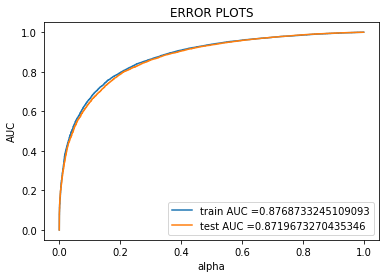

In [ ]:
from sklearn.metrics import roc_curve, auc


clf = LogisticRegression(C=j, penalty= 'l1')
clf.fit(X_train_avgw2v, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, clf.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test_avgw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

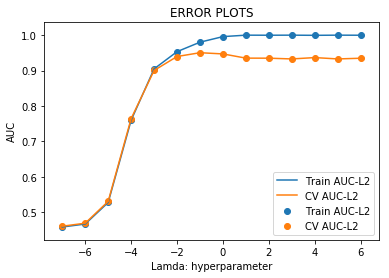

In [ ]:
plt.plot(np.log10(hyper_param), train_auc_l2, label='Train AUC-L2') 
plt.plot(np.log10(hyper_param), cv_auc_l2, label='CV AUC-L2')
plt.scatter(np.log10(hyper_param), train_auc_l2, label='Train AUC-L2') 
plt.scatter(np.log10(hyper_param), cv_auc_l2, label='CV AUC-L2')
plt.legend()
plt.xlabel("Lamda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
clf = LogisticRegression(C=j, penalty= 'l2')

In [ ]:
clf.fit(X_train_avgw2v,Y_train)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X_test_avgw2v)
print(pred)

[1 1 1 ... 1 0 1]


In [ ]:
pred1 = clf.predict(X_train_avgw2v)
print(pred1)

[1 1 1 ... 0 1 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[ 2837,  3719],
       [ 1280, 25164]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[ 4021,  5005],
       [ 1734, 34130]], dtype=int64)

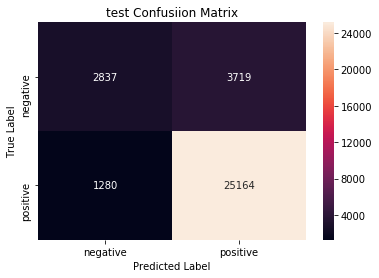

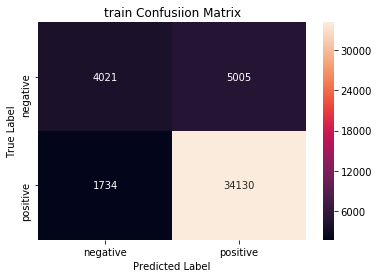

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("train classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.69      0.43      0.53      6556
           1       0.87      0.95      0.91     26444

   micro avg       0.85      0.85      0.85     33000
   macro avg       0.78      0.69      0.72     33000
weighted avg       0.84      0.85      0.83     33000

train classification report
              precision    recall  f1-score   support

           0       0.70      0.45      0.54      9026
           1       0.87      0.95      0.91     35864

   micro avg       0.85      0.85      0.85     44890
   macro avg       0.79      0.70      0.73     44890
weighted avg       0.84      0.85      0.84     44890



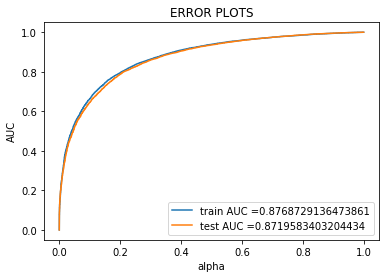

In [ ]:
from sklearn.metrics import roc_curve, auc


clf = LogisticRegression(C=j, penalty= 'l2')
clf.fit(X_train_avgw2v, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, clf.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test_avgw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

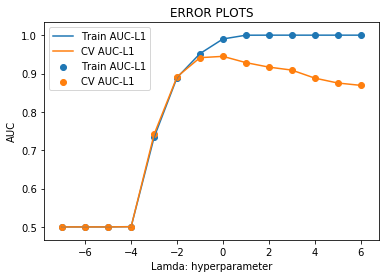

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
def optimal_lamda(X_train_tfidfw2v,Y_train,X_cv_tfidfw2v,Y_cv):
    train_auc_l1 = []
    train_auc_l2 = []
    cv_auc_l1 = []
    cv_auc_l2 = []
    penalty=['l1','l2']
    hyper_param=[10**i for i in range(-7,7)]
    for i in penalty:
        for j in  hyper_param:
            clf = LogisticRegression(C=j, penalty= i)
            clf.fit(X_train_tfidfw2v, Y_train)
            Y_train_pred =  clf.predict_proba(X_train_tfidfw2v)[:,1] 
            Y_cv_pred =  clf.predict_proba(X_cv_tfidfw2v)[:,1]
            if i == 'l1':
                train_auc_l1.append(roc_auc_score(Y_train,Y_train_pred)) 
                cv_auc_l1.append(roc_auc_score(Y_cv, Y_cv_pred))
            else:
                train_auc_l2.append(roc_auc_score(Y_train,Y_train_pred))
                cv_auc_l2.append(roc_auc_score(Y_cv, Y_cv_pred))
                
plt.plot(np.log10(hyper_param), train_auc_l1, label='Train AUC-L1') 
plt.plot(np.log10(hyper_param), cv_auc_l1, label='CV AUC-L1')
plt.scatter(np.log10(hyper_param), train_auc_l1, label='Train AUC-L1') 
plt.scatter(np.log10(hyper_param), cv_auc_l1, label='CV AUC-L1')
plt.legend()
plt.xlabel("Lamda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

In [ ]:
clf = LogisticRegression(C=j, penalty= 'l1')

In [ ]:
clf.fit(X_train_tfidfw2v,Y_train)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X_test_tfidfw2v)
print(pred)

[1 1 1 ... 1 0 1]


In [ ]:
pred1 = clf.predict(X_train_tfidfw2v)
print(pred1)

[1 1 1 ... 0 1 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[ 2258,  4298],
       [ 1168, 25276]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[ 3178,  5848],
       [ 1619, 34245]], dtype=int64)

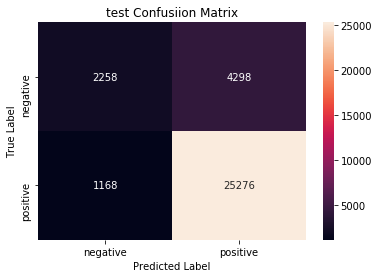

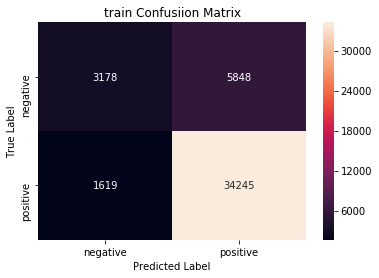

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("train classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.66      0.34      0.45      6556
           1       0.85      0.96      0.90     26444

   micro avg       0.83      0.83      0.83     33000
   macro avg       0.76      0.65      0.68     33000
weighted avg       0.82      0.83      0.81     33000

train classification report
              precision    recall  f1-score   support

           0       0.66      0.35      0.46      9026
           1       0.85      0.95      0.90     35864

   micro avg       0.83      0.83      0.83     44890
   macro avg       0.76      0.65      0.68     44890
weighted avg       0.82      0.83      0.81     44890



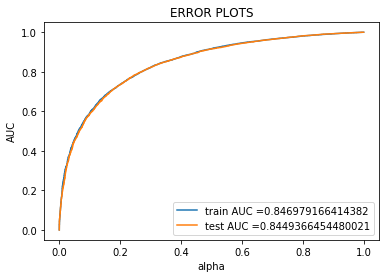

In [ ]:
from sklearn.metrics import roc_curve, auc


clf = LogisticRegression(C=j, penalty= 'l1')
clf.fit(X_train_tfidfw2v, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, clf.predict_proba(X_train_tfidfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test_tfidfw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

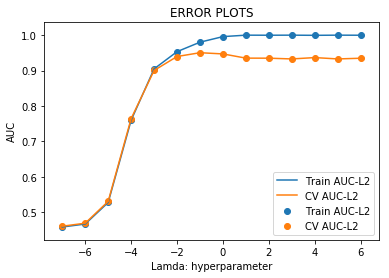

In [ ]:
plt.plot(np.log10(hyper_param), train_auc_l2, label='Train AUC-L2') 
plt.plot(np.log10(hyper_param), cv_auc_l2, label='CV AUC-L2')
plt.scatter(np.log10(hyper_param), train_auc_l2, label='Train AUC-L2') 
plt.scatter(np.log10(hyper_param), cv_auc_l2, label='CV AUC-L2')
plt.legend()
plt.xlabel("Lamda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
clf = LogisticRegression(C=j, penalty= 'l2')

In [ ]:
clf.fit(X_train_tfidfw2v,Y_train)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X_test_tfidfw2v)
print(pred)

[1 1 1 ... 1 0 1]


In [ ]:
pred1 = clf.predict(X_train_tfidfw2v)
print(pred1)

[1 1 1 ... 0 1 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[ 2259,  4297],
       [ 1167, 25277]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[ 3177,  5849],
       [ 1618, 34246]], dtype=int64)

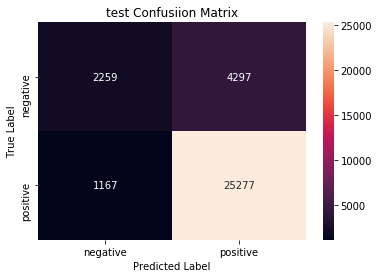

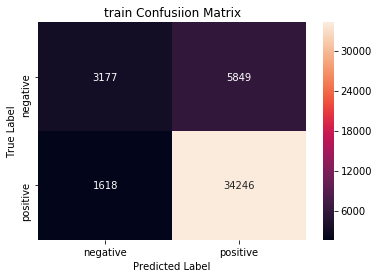

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("train classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.66      0.34      0.45      6556
           1       0.85      0.96      0.90     26444

   micro avg       0.83      0.83      0.83     33000
   macro avg       0.76      0.65      0.68     33000
weighted avg       0.82      0.83      0.81     33000

train classification report
              precision    recall  f1-score   support

           0       0.66      0.35      0.46      9026
           1       0.85      0.95      0.90     35864

   micro avg       0.83      0.83      0.83     44890
   macro avg       0.76      0.65      0.68     44890
weighted avg       0.82      0.83      0.81     44890



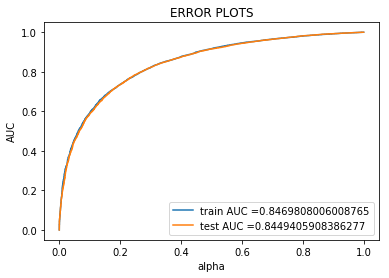

In [ ]:
from sklearn.metrics import roc_curve, auc


clf = LogisticRegression(C=j, penalty= 'l2')
clf.fit(X_train_tfidfw2v, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, clf.predict_proba(X_train_tfidfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test_tfidfw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

# [6] Conclusions

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["model "," l1 train auc", "l1 test auc","l2 train auc",'l2 test auc']
x.add_row([ "bag of words", 1.0 , 0.84, 0.99 ,0.93])
x.add_row( ["tfidf" ,1.0 , 0.94, 1.0 ,0.97])
x.add_row( ["avgw2v" ,0.876, 0.871,0.876,0.871])
x.add_row( ["tfidfw2v" ,0.846 , 0.844 , 0.846, 0.844])
print("comparision of all the models")
print(x.get_string(title="comparision of all the models"))

comparision of all the models
+--------------+---------------+-------------+--------------+-------------+
|    model     |  l1 train auc | l1 test auc | l2 train auc | l2 test auc |
+--------------+---------------+-------------+--------------+-------------+
| bag of words |      1.0      |     0.84    |     0.99     |     0.93    |
|    tfidf     |      1.0      |     0.94    |     1.0      |     0.97    |
|    avgw2v    |     0.876     |    0.871    |    0.876     |    0.871    |
|   tfidfw2v   |     0.846     |    0.844    |    0.846     |    0.844    |
+--------------+---------------+-------------+--------------+-------------+
